# 1. Extract and Aggregate Embeddings

**Purpose**
- Retrieve all transcript segment embeddings for each episode from Neo4j.
- Compute the average embedding for each episode, resulting in a single vector per episode.

## 1.1 Import Required Libraries

In [8]:
# Import necessary libraries for Neo4j connection, numerical computation, and environment variable loading
from neo4j import GraphDatabase
import numpy as np
import os
from dotenv import load_dotenv

These imports allow us to:

- Connect to **Neo4j**
- Handle numerical operations (e.g., **averaging**)
- Securely load credentials from a `.env` file


## Connecting to Neo4j

In [9]:
# Load Neo4j credentials from .env file
load_dotenv()
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USER = os.getenv('NEO4J_USER')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')

# Create a Neo4j driver instance
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

Loads Neo4j connection details from environment variables and establishes a connection to the database.


## 1.3 Extract and Aggregate Embeddings

In [10]:
def get_episode_embeddings(driver):
    """
    For each episode, retrieve all transcript segment embeddings from Neo4j,
    and compute the average embedding for the episode.

    Returns:
        avg_embeddings (dict): {episode_number: np.ndarray (average embedding)}
    """
    episode_embeddings = {}
    with driver.session() as session:
        # Query all transcript segment embeddings for each episode
        result = session.run("""
            MATCH (e:Episode)-[:HAS_SEGMENT]->(s:TranscriptSegment)
            RETURN e.episode_number AS episode, s.embedding AS embedding
        """)
        for record in result:
            ep = record['episode']
            emb = record['embedding']
            if emb is not None:
                if ep not in episode_embeddings:
                    episode_embeddings[ep] = []
                episode_embeddings[ep].append(emb)
    # Compute average embedding for each episode
    avg_embeddings = {}
    for ep, embs in episode_embeddings.items():
        valid_embs = [e for e in embs if e is not None]
        if valid_embs:
            avg_embeddings[ep] = np.mean(np.array(valid_embs), axis=0)
    return avg_embeddings

# Run the function to get average embeddings for all episodes
avg_embeddings = get_episode_embeddings(driver)

- Queries Neo4j for all transcript segment embeddings, grouped by episode.  
- Computes the average embedding for each episode, resulting in a dictionary that maps episode numbers to their corresponding average embedding vectors.  
- The resulting `avg_embeddings` is used in subsequent steps for similarity computation.


## 1.4 Inspect the Output

In [11]:
# Print the number of episodes and the shape of one embedding for verification
print(f"Number of episodes with embeddings: {len(avg_embeddings)}")
if avg_embeddings:
    first_ep = next(iter(avg_embeddings))
    print(f"Shape of embedding vector: {np.array(avg_embeddings[first_ep]).shape}")

Number of episodes with embeddings: 395
Shape of embedding vector: (384,)


- Verification step to confirm that embeddings were successfully extracted and averaged.  
- Provides insight into the dimensionality of the resulting embedding vectors.

It was previous verified that all embedding vectors follows the same shape (384,) and confirmed that the embeddings values are not the same. 


# 2. Compute Cosine Similarity Matrix

**Purpose**

- Calculate the cosine similarity between every unique pair of episodes using their averaged embeddings.  
- Store the results in:
  - a **matrix** for visualization (e.g., heatmaps), or  
  - a **list** for further analysis (e.g., thresholding or ranking).


## 2.1 Import Required Library

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

Uses `cosine_similarity` from scikit-learn to efficiently compute pairwise similarities between embedding vectors.


## 2.2 Prepare Embedding Matrix and Episode List

In [13]:
# Prepare a sorted list of episode numbers and a corresponding matrix of embeddings
episode_numbers = sorted(avg_embeddings.keys())
embedding_matrix = np.stack([avg_embeddings[ep] for ep in episode_numbers])

- `episode_numbers` is a sorted list containing all episode numbers with available embeddings.  
- `embedding_matrix` is a 2D NumPy array where each row corresponds to the averaged embedding of an episode.


## 2.3 Compute Cosine Similarity Matrix

In [14]:
# Compute the full cosine similarity matrix
similarity_matrix = cosine_similarity(embedding_matrix)


- `similarity_matrix` is a square matrix where `similarity_matrix[i, j]` represents the cosine similarity between episode *i* and episode *j*.  
- The diagonal values are `1.0`, indicating that each episode is perfectly similar to itself.


## 2.4 Store Similarity Scores as a List of Tuples

In [15]:
# Create a list of (episode_A, episode_B, similarity) for all unique pairs (excluding self-pairs)
similarity_scores = []
num_episodes = len(episode_numbers)
for i in range(num_episodes):
    for j in range(num_episodes):
        if i != j:
            similarity_scores.append((
                episode_numbers[i],
                episode_numbers[j],
                similarity_matrix[i, j]
            ))

- Creates a list of tuples for all episode pairs (A, B) with their similarity score, excluding self-pairs.  
- This format is useful for filtering, thresholding, and creating relationships.


## 2.5 Quick Inspection

In [16]:
# Print a few example similarity scores
print("Sample similarity scores (episode_A, episode_B, similarity):")
for row in similarity_scores[:5]:
    print(row)

Sample similarity scores (episode_A, episode_B, similarity):
(1, 2, np.float64(0.6790425881474818))
(1, 3, np.float64(0.738388150561435))
(1, 4, np.float64(0.8391352125299666))
(1, 5, np.float64(0.8465348975474954))
(1, 6, np.float64(0.8202063633064138))


- Creates a list of tuples for all episode pairs (A, B) with their similarity score, excluding self-pairs.  
- This format is useful for filtering, thresholding, and creating relationships.

Previous inspections revealed similarity scores higher than 0.9, while current analysis shows the presence of lower scores as well. This confirms the need to define a high threshold to ensure that new `:SIMILAR_TO` relationships are created only between episodes that are genuinely similar.


## 3. Explore Similarity Distribution

**Purpose**

Visualize and summarize the distribution of cosine similarity scores between episodes.  
This helps in understanding the range and clustering of similarities and guides the selection of an appropriate threshold for creating relationships.


## 3.1 Extract All Similarity Scores (Excluding Self-Pairs)

In [17]:
# Extract all similarity scores (excluding self-pairs)
all_scores = []
num_episodes = len(episode_numbers)
for i in range(num_episodes):
    for j in range(num_episodes):
        if i != j:
            all_scores.append(similarity_matrix[i, j])

Creates a flat list of all pairwise similarity scores, excluding self-similarity.


## 3.2 Visualize the Distribution (Histogram)

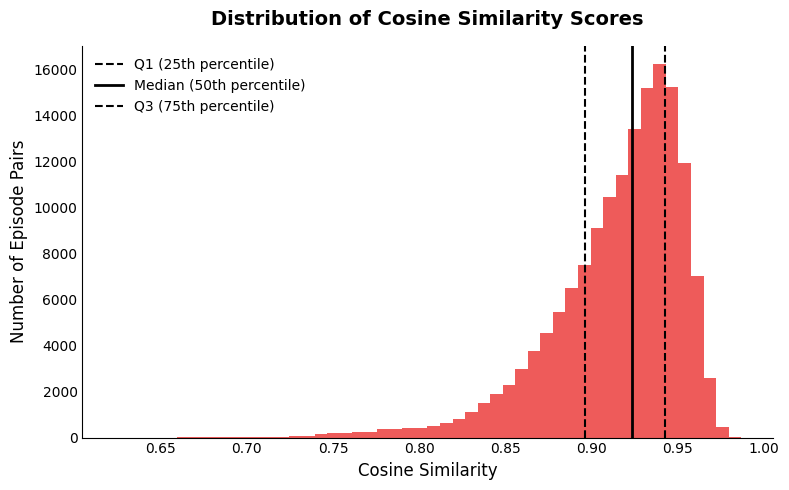

In [18]:
import matplotlib.pyplot as plt
import numpy as np

main_color = '#EC3E3D'  # Main color

# Calculate quartiles
q1 = np.percentile(all_scores, 25)
median = np.percentile(all_scores, 50)
q3 = np.percentile(all_scores, 75)

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(all_scores, bins=50, color=main_color, edgecolor='none', alpha=0.85)

# Add vertical lines for Q1, Median, and Q3
ax.axvline(q1, color='black', linestyle='--', linewidth=1.5, label='Q1 (25th percentile)')
ax.axvline(median, color='black', linestyle='-', linewidth=2, label='Median (50th percentile)')
ax.axvline(q3, color='black', linestyle='--', linewidth=1.5, label='Q3 (75th percentile)')

# Minimalist tweaks
ax.set_title('Distribution of Cosine Similarity Scores', fontsize=14, weight='bold', pad=15)
ax.set_xlabel('Cosine Similarity', fontsize=12)
ax.set_ylabel('Number of Episode Pairs', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.legend(frameon=False, fontsize=10, loc='upper left')
plt.tight_layout()
plt.show()

This histogram shows how similarity scores are distributed across all episode pairs.  
It can be used to identify clusters, long tails, or natural cutoffs in the similarity values.


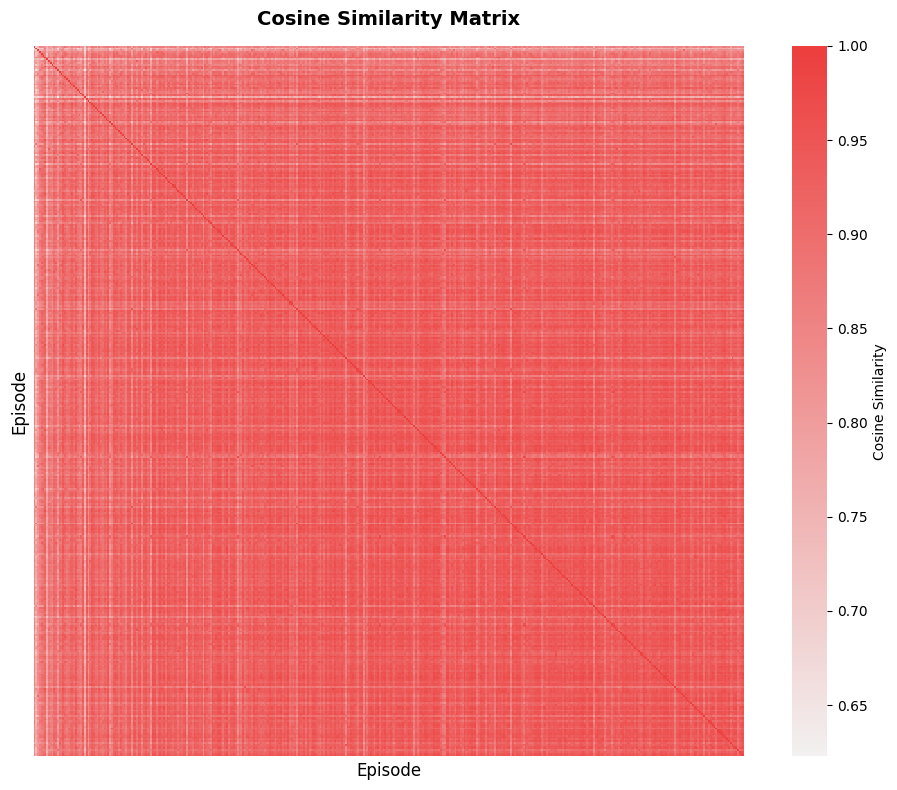

In [19]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(
    similarity_matrix,
    cmap=sns.light_palette(main_color, as_cmap=True),
    xticklabels=episode_numbers,
    yticklabels=episode_numbers,
    cbar_kws={'label': 'Cosine Similarity'},
    square=True,
    linewidths=0,
    linecolor='white'
)

plt.title('Cosine Similarity Matrix', fontsize=14, weight='bold', pad=15)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Episode', fontsize=12)
plt.xticks([], [])  
plt.yticks([], [])
plt.tight_layout()
plt.show()

## 3.4 Summary Statistics

In [20]:
import numpy as np

print("Summary statistics for cosine similarity scores (excluding self-pairs):")
print(f"Min:    {np.min(all_scores):.3f}")
print(f"Max:    {np.max(all_scores):.3f}")
print(f"Mean:   {np.mean(all_scores):.3f}")
print(f"Median: {np.median(all_scores):.3f}")
print(f"90th percentile: {np.percentile(all_scores, 90):.3f}")
print(f"95th percentile: {np.percentile(all_scores, 95):.3f}")
print(f"99th percentile: {np.percentile(all_scores, 99):.3f}")

Summary statistics for cosine similarity scores (excluding self-pairs):
Min:    0.623
Max:    0.987
Mean:   0.915
Median: 0.924
90th percentile: 0.954
95th percentile: 0.960
99th percentile: 0.968


Summary statistics show consistently high similarity scores, with a median of 0.924. This indicates that most episodes are considered similar when using cosine similarity. To ensure that only the most semantically aligned episodes are linked, a higher threshold should be adopted when creating `:SIMILAR_TO` relationships.


## 3.5. Inspect Pairs Near a Candidate Threshold

In [21]:
# Example: Show episode pairs with similarity above 0.9
candidate_threshold = 0.97
high_sim_pairs = [row for row in similarity_scores if row[2] >= candidate_threshold]

print(f"Number of episode pairs with similarity >= {candidate_threshold}: {len(high_sim_pairs)}")
for epA, epB, score in high_sim_pairs[:10]:  # Show up to 10 examples
    print(f"Episode {epA} <-> Episode {epB}: similarity = {score:.3f}")

Number of episode pairs with similarity >= 0.97: 1004
Episode 69 <-> Episode 80: similarity = 0.972
Episode 69 <-> Episode 111: similarity = 0.972
Episode 74 <-> Episode 307: similarity = 0.972
Episode 80 <-> Episode 69: similarity = 0.972
Episode 80 <-> Episode 300: similarity = 0.972
Episode 80 <-> Episode 400: similarity = 0.971
Episode 83 <-> Episode 123: similarity = 0.973
Episode 87 <-> Episode 400: similarity = 0.971
Episode 95 <-> Episode 184: similarity = 0.978
Episode 95 <-> Episode 211: similarity = 0.975


Given the high number of episodes with elevated similarity scores, a threshold of 0.97 has been established as the initial benchmark for testing. The relationships formed will be visually inspected to determine whether the episodes are genuinely similar. 
Alternatively, if the results from this initial test are unsatisfactory, we will explore the option of selecting the top N most similar episodes for further analysis.

# 4. Choose a Similarity Threshold and Inspect Episode Pairs

**Purpose**

Filter episode pairs to include only those with cosine similarity scores ≥ 0.97.  
This step ensures that the selected connections are both meaningful and thematically relevant.


## 4.1 Filter Episode Pairs by Threshold

In [22]:
# Set your chosen threshold
threshold = 0.97

# Filter pairs with similarity >= threshold
selected_pairs = [row for row in similarity_scores if row[2] >= threshold]

print(f"Number of episode pairs with similarity >= {threshold}: {len(selected_pairs)}")

Number of episode pairs with similarity >= 0.97: 1004


Filters the list of all episode pairs to include only those with a similarity score at or above the chosen threshold (0.97).


## 4.2 Inspect Episode Pairs and Their Themes

In [23]:
import pandas as pd

# Load the CSV file with episode metadata
episodes_df = pd.read_csv(r'G:\My Drive\Projects\naruhodo_references\references_Link\Podcast_Neo4j\data\processed\naruhodo_episodes.csv')

In [24]:
# Create a mapping from episode number to episode title
episode_to_title = pd.Series(
    episodes_df['episode_title'].values, 
    index=episodes_df['episode_number']
).to_dict()

In [28]:
# Print the first 10 highly similar episode pairs with their titles
for epA, epB, score in selected_pairs[200:250]:
    titleA = episode_to_title.get(epA, "Unknown Title")
    titleB = episode_to_title.get(epB, "Unknown Title")
    print(f"Episode {epA} ({titleA}) <-> Episode {epB} ({titleB}): similarity = {score:.3f}")

Episode 225 (A Voz Em Nossa Cabeca Existe Para Todos) <-> Episode 349 (O Que Sao Relacoes Parassociais): similarity = 0.971
Episode 225 (A Voz Em Nossa Cabeca Existe Para Todos) <-> Episode 353 (Por Que Pedimos Desculpas Parte 2 De 2): similarity = 0.973
Episode 225 (A Voz Em Nossa Cabeca Existe Para Todos) <-> Episode 382 (Quem Ama O Feio Bonito Lhe Parece): similarity = 0.971
Episode 225 (A Voz Em Nossa Cabeca Existe Para Todos) <-> Episode 391 (Por Que Sentimos Inveja): similarity = 0.972
Episode 225 (A Voz Em Nossa Cabeca Existe Para Todos) <-> Episode 393 (A Psicologia Positiva Tem Validade Cientifica Parte 1 De 2): similarity = 0.972
Episode 225 (A Voz Em Nossa Cabeca Existe Para Todos) <-> Episode 394 (A Psicologia Positiva Tem Validade Cientifica Parte 2 De 2): similarity = 0.973
Episode 225 (A Voz Em Nossa Cabeca Existe Para Todos) <-> Episode 407 (Existe Razao Sem Emocao): similarity = 0.970
Episode 225 (A Voz Em Nossa Cabeca Existe Para Todos) <-> Episode 412 (Por Que Traimo

# Through qualitative analysis, it is evident that the relationships between episodes are logical and coherent. 
# * Note: 
# - Many of the earlier episodes consist of challenges, which may not align well with the objectives of this project. It might be beneficial to clean these up.
# - Additionally, there are several episodes with unknown titles, indicating an opportunity for data improvement.

## 4.3 Explore All Highly Similar Pairs for a Single Episode

In [33]:
target_episode = 239
high_sim_for_target = [
    (epA, epB, score) for epA, epB, score in selected_pairs if epA == target_episode or epB == target_episode
]

related_episodes = set()

for epA, epB, score in high_sim_for_target:
    other_ep = epB if epA == target_episode else epA
    related_episodes.add(other_ep)
    other_title = episode_to_title.get(other_ep, "Unknown Title")
    print(f"Episode {target_episode} <-> Episode {other_ep} ({other_title}): similarity = {score:.3f}")

print(f"\nNumber of unique episodes related to episode {target_episode}: {len(related_episodes)}")

Episode 239 <-> Episode 140 (Por Que Expressamos Tanta Raiva Nas Redes Sociais): similarity = 0.973
Episode 239 <-> Episode 221 (Existe Causa Para A Depressao Parte 2 De 2): similarity = 0.972
Episode 239 <-> Episode 238 (O Distancionamento Social Impacta A Nossa Saude Mental Parte 1 De 2): similarity = 0.981
Episode 239 <-> Episode 140 (Por Que Expressamos Tanta Raiva Nas Redes Sociais): similarity = 0.973
Episode 239 <-> Episode 221 (Existe Causa Para A Depressao Parte 2 De 2): similarity = 0.972
Episode 239 <-> Episode 238 (O Distancionamento Social Impacta A Nossa Saude Mental Parte 1 De 2): similarity = 0.981
Episode 239 <-> Episode 261 (O Que A Solidao Pode Causar Nas Pessoas): similarity = 0.977
Episode 239 <-> Episode 305 (Por Que Seguimos Lideres): similarity = 0.971
Episode 239 <-> Episode 353 (Por Que Pedimos Desculpas Parte 2 De 2): similarity = 0.975
Episode 239 <-> Episode 394 (A Psicologia Positiva Tem Validade Cientifica Parte 2 De 2): similarity = 0.972
Episode 239 <->

# 5. Create SIMILAR_TO Relationships in Neo4j# 

**Purpose**

For each episode pair with similarity ≥ 0.97, create two `:SIMILAR_TO` relationships in Neo4j:  
`(:Episode {A})-[:SIMILAR_TO {score: ...}]->(:Episode {B})`  
`(:Episode {B})-[:SIMILAR_TO {score: ...}]->(:Episode {A})`  
The similarity score is stored as a property on each relationship.


## 5.2 Prepare Data for Batch Insertion

In [35]:
batch_size = 1000  # Adjust as needed for your environment

with driver.session() as session:
    # 1. Remove all existing SIMILAR_TO relationships
    session.run("MATCH ()-[r:SIMILAR_TO]->() DELETE r")
    print("All existing SIMILAR_TO relationships removed.")

    # 2. Prepare data for both directions
    relationships = []
    for epA, epB, score in selected_pairs:
        relationships.append({'source': epA, 'target': epB, 'score': float(score)})
        relationships.append({'source': epB, 'target': epA, 'score': float(score)})

    # 3. Batch insert new SIMILAR_TO relationships
    for i in range(0, len(relationships), batch_size):
        batch = relationships[i:i+batch_size]
        session.run("""
            UNWIND $batch AS rel
            MATCH (a:Episode {episode_number: rel.source})
            MATCH (b:Episode {episode_number: rel.target})
            MERGE (a)-[r:SIMILAR_TO]->(b)
            SET r.score = rel.score
        """, batch=batch)
        print(f"Inserted batch {i//batch_size + 1} of SIMILAR_TO relationships.")

    # 4. Validate the number of relationships created
    result = session.run("MATCH ()-[r:SIMILAR_TO]->() RETURN count(r) AS rel_count")
    print("Number of SIMILAR_TO relationships in the database:", result.single()["rel_count"])

All existing SIMILAR_TO relationships removed.
Inserted batch 1 of SIMILAR_TO relationships.
Inserted batch 2 of SIMILAR_TO relationships.
Inserted batch 3 of SIMILAR_TO relationships.
Number of SIMILAR_TO relationships in the database: 1004


# 6. Exploration of :SIMILAR_TO RELATIONSHIP

## 6.1 Count the Number of SIMILAR_TO Relationships per Episode

In [37]:
with driver.session() as session:
    result = session.run("""
        MATCH (e:Episode)-[r:SIMILAR_TO]->()
        RETURN e.episode_number AS episode_number, e.title AS title, count(r) AS num_similar_episodes
        ORDER BY num_similar_episodes DESC
        LIMIT 20
    """)
    for record in result:
        print(record)

<Record episode_number=285 title='Por Que Outras Pessoas Nao Entendem Coisas Que Sao Obvias Para Nos' num_similar_episodes=42>
<Record episode_number=348 title='Sentir Medo E Ansiedade E Algo Ruim' num_similar_episodes=39>
<Record episode_number=394 title='A Psicologia Positiva Tem Validade Cientifica Parte 2 De 2' num_similar_episodes=36>
<Record episode_number=225 title='A Voz Em Nossa Cabeca Existe Para Todos' num_similar_episodes=33>
<Record episode_number=259 title='Por Que As Coisas Parecem Obvias Depois Que Passamos Por Elas Parte 1 De 2' num_similar_episodes=32>
<Record episode_number=261 title='O Que A Solidao Pode Causar Nas Pessoas' num_similar_episodes=32>
<Record episode_number=353 title='Por Que Pedimos Desculpas Parte 2 De 2' num_similar_episodes=27>
<Record episode_number=382 title='Quem Ama O Feio Bonito Lhe Parece' num_similar_episodes=24>
<Record episode_number=391 title='Por Que Sentimos Inveja' num_similar_episodes=21>
<Record episode_number=376 title='Como Fazer A

# 6.2 Visualize a Similarity Neighborhood for a Given Episode

In [39]:
target_episode = 407
threshold = 0.97
with driver.session() as session:
    result = session.run("""
        MATCH (e:Episode {episode_number: $ep})- [r:SIMILAR_TO]-> (other:Episode)
        WHERE r.score >= $thresh
        RETURN e.episode_number AS source, other.episode_number AS target, r.score AS score
    """, ep=target_episode, thresh=threshold)
    for record in result:
        print(record)

<Record source=407 target=230 score=0.972052942437058>
<Record source=407 target=357 score=0.9712916141168643>
<Record source=407 target=353 score=0.9710688852080224>
<Record source=407 target=376 score=0.9702285725059262>
<Record source=407 target=434 score=0.9710766324722615>
<Record source=407 target=348 score=0.9731125603680446>
<Record source=407 target=378 score=0.9708416745473273>
<Record source=407 target=394 score=0.9717946109622934>
<Record source=407 target=259 score=0.9721647046105035>
<Record source=407 target=136 score=0.970925422510296>
<Record source=407 target=225 score=0.9700433564771195>
<Record source=407 target=285 score=0.9745996966944886>
<Record source=407 target=281 score=0.9734302833120969>
<Record source=407 target=174 score=0.9706815611424638>
<Record source=407 target=241 score=0.9715699232528348>


## 6.3 Get the Distribution of Similarity Scores

In [40]:
with driver.session() as session:
    result = session.run("""
        MATCH ()-[r:SIMILAR_TO]->()
        RETURN percentileCont(r.score, 0.5) AS median,
               min(r.score) AS min,
               max(r.score) AS max,
               avg(r.score) AS mean
    """)
    stats = result.single()
    print("Similarity score stats:", stats)

Similarity score stats: <Record median=0.9721526315559061 min=0.9700029955753168 max=0.986888369375088 mean=0.9729110956363437>


For the complete script that handles the creation of :SIMILAR_TO relationships, please refer to the [create_similar_to_relationships.py](../scripts/create_similar_to_relationships.py) file.